# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Libraries and set environment

In [ ]:
%cd {'drive/MyDrive/DJIA'}

/content/drive/MyDrive/DJIA


In [ ]:
%matplotlib inline
from pathlib import Path

# basic data manipuation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# tensorflow utils for neural nets
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization

from tensorflow import keras

# evaluation metrics
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr

In [ ]:
# Check for gpu devices
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [ ]:
sns.set_style('whitegrid')
np.random.seed(123)

# Load Datasets

In [ ]:
indicators_df = pd.read_csv('data/indicators_df.csv')
indicators_df.set_index('Date', inplace=True)

# Univariate LSTM Regression

In [ ]:
results_simple_lstm = Path('results', 'simple_lstm')
if not results_simple_lstm.exists():
    results_simple_lstm.mkdir(parents=True)

In [ ]:
djia_fda_close = pd.DataFrame(indicators_df['Adj Close'])
djia_fda_close

,Adj Close
Date,
2008-08-08,11734.320312
2008-08-11,11782.349609
2008-08-12,11642.469727
2008-08-13,11532.959961
2008-08-14,11615.929688
...,...
2016-06-27,17140.240234
2016-06-28,17409.720703
2016-06-29,17694.679688


## Preprocessing

In [ ]:
scaler = MinMaxScaler()

In [ ]:
djia_fda_scaled = pd.Series(scaler.fit_transform(djia_fda_close).squeeze(), 
                         index=djia_fda_close.index)
djia_fda_scaled.describe()

count    1989.000000
mean        0.587827
std         0.267226
min         0.000000
25%         0.371118
50%         0.550645
75%         0.844120
max         1.000000
dtype: float64

In [ ]:
from src.ts_utils import rnn

In [ ]:
window = 60
X, y = rnn.create_univariate_rnn_data(djia_fda_scaled, window)

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-11-03,0.440894,0.444976,0.433087,0.423779,0.430832,0.434569,0.419226,0.408105,0.413960,0.415046,0.431863,0.411310,0.413572,0.421191,0.439267,0.424714,0.422416,0.423773,0.394479,0.397261,0.421891,0.398091,0.401337,0.415344,0.414348,0.371469,0.383497,0.345303,0.380154,0.411496,0.379814,0.366085,0.363621,0.380355,0.390646,0.324547,0.365787,0.364122,0.334525,0.321141,0.289703,0.246492,0.230427,0.172723,0.161843,0.241435,0.234922,0.172614,0.206727,0.195929,0.231050,0.211350,0.167625,0.182247,0.155703,0.138434,0.214024,0.207721,0.223847,0.236114
2008-11-04,0.444976,0.433087,0.423779,0.430832,0.434569,0.419226,0.408105,0.413960,0.415046,0.431863,0.411310,0.413572,0.421191,0.439267,0.424714,0.422416,0.423773,0.394479,0.397261,0.421891,0.398091,0.401337,0.415344,0.414348,0.371469,0.383497,0.345303,0.380154,0.411496,0.379814,0.366085,0.363621,0.380355,0.390646,0.324547,0.365787,0.364122,0.334525,0.321141,0.289703,0.246492,0.230427,0.172723,0.161843,0.241435,0.234922,0.172614,0.206727,0.195929,0.231050,0.211350,0.167625,0.182247,0.155703,0.138434,0.214024,0.207721,0.223847,0.236114,0.235674
2008-11-05,0.433087,0.423779,0.430832,0.434569,0.419226,0.408105,0.413960,0.415046,0.431863,0.411310,0.413572,0.421191,0.439267,0.424714,0.422416,0.423773,0.394479,0.397261,0.421891,0.398091,0.401337,0.415344,0.414348,0.371469,0.383497,0.345303,0.380154,0.411496,0.379814,0.366085,0.363621,0.380355,0.390646,0.324547,0.365787,0.364122,0.334525,0.321141,0.289703,0.246492,0.230427,0.172723,0.161843,0.241435,0.234922,0.172614,0.206727,0.195929,0.231050,0.211350,0.167625,0.182247,0.155703,0.138434,0.214024,0.207721,0.223847,0.236114,0.235674,0.261635
2008-11-06,0.423779,0.430832,0.434569,0.419226,0.408105,0.413960,0.415046,0.431863,0.411310,0.413572,0.421191,0.439267,0.424714,0.422416,0.423773,0.394479,0.397261,0.421891,0.398091,0.401337,0.415344,0.414348,0.371469,0.383497,0.345303,0.380154,0.411496,0.379814,0.366085,0.363621,0.380355,0.390646,0.324547,0.365787,0.364122,0.334525,0.321141,0.289703,0.246492,0.230427,0.172723,0.161843,0.241435,0.234922,0.172614,0.206727,0.195929,0.231050,0.211350,0.167625,0.182247,0.155703,0.138434,0.214024,0.207721,0.223847,0.236114,0.235674,0.261635,0.220327
2008-11-07,0.430832,0.434569,0.419226,0.408105,0.413960,0.415046,0.431863,0.411310,0.413572,0.421191,0.439267,0.424714,0.422416,0.423773,0.394479,0.397261,0.421891,0.398091,0.401337,0.415344,0.414348,0.371469,0.383497,0.345303,0.380154,0.411496,0.379814,0.366085,0.363621,0.380355,0.390646,0.324547,0.365787,0.364122,0.334525,0.321141,0.289703,0.246492,0.230427,0.172723,0.161843,0.241435,0.234922,0.172614,0.206727,0.195929,0.231050,0.211350,0.167625,0.182247,0.155703,0.138434,0.214024,0.207721,0.223847,0.236114,0.235674,0.261635,0.220327,0.182633


In [ ]:
djia_fda_scaled

Date
2008-08-08    0.440894
2008-08-11    0.444976
2008-08-12    0.433087
2008-08-13    0.423779
2008-08-14    0.430832
                ...   
2016-06-27    0.900373
2016-06-28    0.923277
2016-06-29    0.947497
2016-06-30    0.967498
2016-07-01    0.969145
Length: 1989, dtype: float64

In [ ]:
y.head()

Date
2008-11-03    0.235674
2008-11-04    0.261635
2008-11-05    0.220327
2008-11-06    0.182633
2008-11-07    0.203714
dtype: float64

In [ ]:
X.shape, y.shape

((1929, 60), (1929,))

## Train-Test split

Since our dataset goes from late $2008$ to mid $2016$, we will use data from $2015$ as our test.

In [ ]:
# train
X_train = X[:'2015'].values.reshape(-1, window, 1)  # 3D for LSTM
y_train = y[:'2015']

# test:
X_test = X['2015':].values.reshape(-1, window, 1)
y_test = y['2015':]

In [ ]:
n_obs, window, n_features = X_train.shape

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1551, 60, 1), (1551,), (378, 60, 1), (378,))

About $80\%$ of the data has been left for training and the rest as test.

## Define The Model Architecture

In [ ]:
rnn_net = Sequential([
                      LSTM(units=50, 
                           input_shape=(window, n_features), name='LSTM'),
                      Dense(1, name='Output')
])

Let's check how many parameters have we got.

In [ ]:
rnn_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 50)                10400     
                                                                 
 Output (Dense)              (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [ ]:
optimizer = keras.optimizers.RMSprop(epsilon=1e-08)

In [ ]:
rnn_net.compile(loss='mean_squared_error',
                optimizer=optimizer)

In [ ]:
# Early stopping callback
rnn_path = (results_simple_lstm /'simple_rnn.h5').as_posix()
checkpoint = ModelCheckpoint(filepath=rnn_path,
                             verbose=1,
                             monitor='val_loss',
                             save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

In [ ]:
lstm_trained = rnn_net.fit(X_train,
                           y_train,
                           epochs=150,
                           batch_size=20,
                           shuffle=True,
                           validation_data=(X_test, y_test),
                           callbacks=[early_stopping, checkpoint],
                           verbose=1)

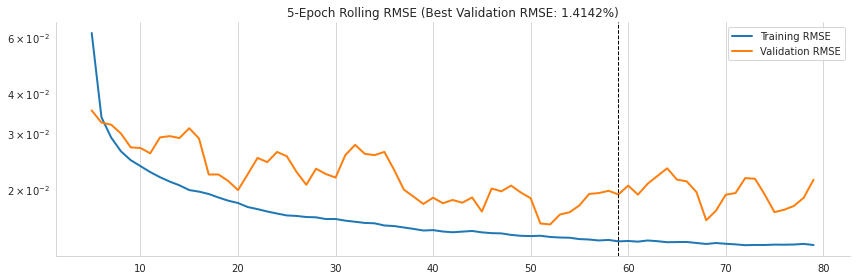

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_trained.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_simple_lstm / 'rnn_djia_fda_error', dpi=300);

In [ ]:
train_rmse_scaled = np.sqrt(rnn_net.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_net.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0106 | Test RMSE: 0.0141


In [ ]:
train_predict_scaled = rnn_net.predict(X_train)
test_predict_scaled = rnn_net.predict(X_test)

In [ ]:
from scipy.stats import spearmanr
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9987 | Test IC: 0.9261


## Rescale predictions

In [ ]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))

In [ ]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [ ]:
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 124.17 | Test RMSE: 166.39'

In [ ]:
djia_fda_close['Train Predictions'] = train_predict
djia_fda_close['Test Predictions'] = test_predict
djia_fda_close = djia_fda_close.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

## Plot Results

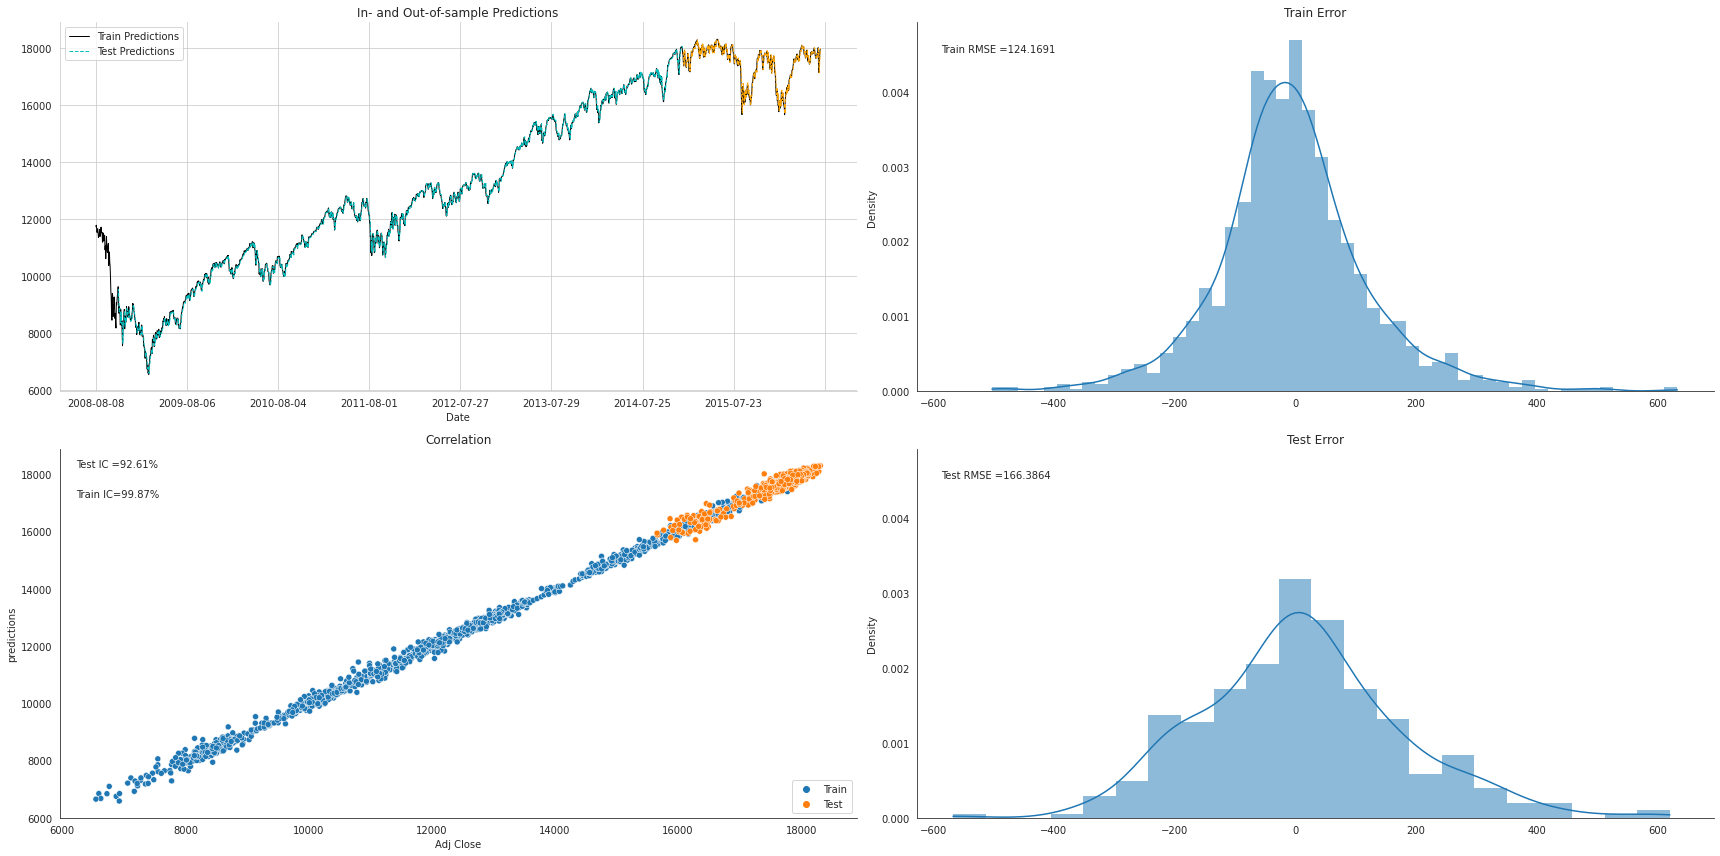

In [ ]:
fig=plt.figure(figsize=(24,12))
ax1 = plt.subplot(221)

djia_fda_close.loc[:, 'Adj Close'].plot(lw=1, ax=ax1, c='k', label='Adj close')
djia_fda_close.loc[:, ['Train Predictions']].plot(lw=1, ax=ax1, color='c', ls='--', label='Train Predictions')
djia_fda_close.loc[:, ['Test Predictions']].plot(lw=1, ax=ax1, color='orange', ls='--', label='Test Predictions')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Adj Close', y='predictions', data=djia_fda_close, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.histplot(train_predict.squeeze()- y_train_rescaled, ax=ax2, kde=True, stat="density", linewidth=0)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.histplot(test_predict.squeeze()-y_test_rescaled, ax=ax4, kde=True, stat="density", linewidth=0)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_simple_lstm / 'rnn_djia_fda_regression', dpi=300);

In [ ]:
djia_fda_close['Label'] = list(combined_news['Label'])

In [ ]:
djia_fda_close['preds'] = list((djia_fda_close['predictions'].shift(1) > djia_fda_close['predictions']).astype(int))

In [ ]:
(djia_fda_close[window:]['Label'] == djia_fda_close[window:]['preds']).sum()/len(djia_fda_close[window:])

0.5173665111456713

In [ ]:
djia_fda_close[window:]

,Adj Close,Train Predictions,Test Predictions,predictions,data,Label,preds
Date,,,,,,,
2008-11-03,9319.830078,9281.201172,NaN,9281.201172,Train,0,0
2008-11-04,9625.280273,9282.227539,NaN,9282.227539,Train,1,0
2008-11-05,9139.269531,9533.087891,NaN,9533.087891,Train,0,0
2008-11-06,8695.790039,9176.687500,NaN,9176.687500,Train,0,1
2008-11-07,8943.809570,8742.295898,NaN,8742.295898,Train,1,1
...,...,...,...,...,...,...,...
2016-06-27,17140.240234,NaN,17362.949219,17362.949219,Test,0,1
2016-06-28,17409.720703,NaN,17132.128906,17132.128906,Test,1,1
2016-06-29,17694.679688,NaN,17431.855469,17431.855469,Test,1,0


# LSTM for Classification

In [ ]:
results_path = Path('results', 'lstm_embeddings')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Build dataset

In [ ]:
# indicators_df

In [ ]:
from src.ts_utils import rnn

In [ ]:
daily_returns = pd.DataFrame(indicators_df[['Returns']])

In [ ]:
window = 61
daily_returns, _ = rnn.create_univariate_rnn_data(daily_returns, window)
daily_returns = daily_returns.rename(columns={0: 'fwd_returns'})
daily_returns['Label'] = (daily_returns['fwd_returns'] > 0).astype(int)

In [ ]:
daily_returns

,fwd_returns,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-11-04,0.000294,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,-0.014920,0.110803,-0.008162,-0.078733,0.046789,-0.014148,0.046679,-0.025014,-0.056948,0.020194,-0.035933,-0.024249,0.108779,-0.008181,0.021102,0.015720,-0.000555,1
2008-11-05,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,-0.014920,0.110803,-0.008162,-0.078733,0.046789,-0.014148,0.046679,-0.025014,-0.056948,0.020194,-0.035933,-0.024249,0.108779,-0.008181,0.021102,0.015720,-0.000555,0.032774,1
2008-11-06,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,-0.014920,0.110803,-0.008162,-0.078733,0.046789,-0.014148,0.046679,-0.025014,-0.056948,0.020194,-0.035933,-0.024249,0.108779,-0.008181,0.021102,0.015720,-0.000555,0.032774,-0.050493,0
2008-11-07,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,-0.014920,0.110803,-0.008162,-0.078733,0.046789,-0.014148,0.046679,-0.025014,-0.056948,0.020194,-0.035933,-0.024249,0.108779,-0.008181,0.021102,0.015720,-0.000555,0.032774,-0.050493,-0.048525,0
2008-11-10,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,-0.014920,0.110803,-0.008162,-0.078733,0.046789,-0.014148,0.046679,-0.025014,-0.056948,0.020194,-0.035933,-0.024249,0.108779,-0.008181,0.021102,0.015720,-0.000555,0.032774,-0.050493,-0.048525,0.028522,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.001782,0.006088,-0.003133,-0.007537,0.006404,-0.009827,0.001995,-0.001169,0.009389,0.010554,0.001014,-0.001616,0.005962,0.002746,0.002364,-0.006286,0.001181,-0.001472,0.000728,0.002848,-0.011684,-0.003203,0.006612,-0.007839,-0.005614,0.000535,0.004525,-0.001957,0.012563,-0.012117,0.000530,-0.010450,0.010002,-0.010205,-0.000192,-0.005205,0.003759,-0.000458,0.012183,0.008215,-0.001301,0.002520,-0.004813,0.000139,0.002748,-0.001766,0.006361,0.001002,0.003722,-0.001103,-0.006664,-0.007437,-0.003252,

In [ ]:
daily_returns.to_hdf('data/ts_cl.h5', 'daily_returns_lstm')

/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


In [ ]:
!pip install --upgrade -q tables

     |████████████████████████████████| 5.9 MB 11.6 MB/s 


In [ ]:
daily_returns = pd.read_hdf('data/ts_cl.h5', 'daily_returns_lstm')

In [ ]:
%ls data

clean_reddit_news.csv   lab_df.csv                 reddit_ngram_news.csv
Combined_News_DJIA.csv  news_with_topic_label.csv  ts_cl.h5
encoded_topics_df.csv   ngrams_df.csv              upload_DJIA_table.csv
indicators_df.csv       RedditNews.csv


In [ ]:
news_topics = pd.read_csv('data/encoded_topics_df.csv')

In [ ]:
news_topics = news_topics.add_prefix('topic_')

In [ ]:
news_topics.index = pd.to_datetime(news_topics['topic_Date'])

In [ ]:
news_topics.drop(['topic_Date', 'topic_Label'], axis=1, inplace=True)

In [ ]:
data = pd.merge(daily_returns, news_topics, left_index=True, right_index=True)

In [ ]:
data.to_hdf('data/ts_cl.h5', 'returns_and_topics')

/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


In [ ]:
!pip install --upgrade -q tables
rnt_data = pd.read_hdf('data/ts_cl.h5', 'returns_and_topics')

## Add Feature Engineering from Stock Market

In [ ]:
stock_indicators = pd.read_csv('data/indicators_df.csv')

In [ ]:
stock_indicators.index = pd.to_datetime(stock_indicators['Date'])

In [ ]:
stock_indicators.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Returns', 'Frac_diff_adjClose'], axis=1, inplace=True)

Use only those columns with more than 5\% correlation with the training set.

In [ ]:
corr = stock_indicators[:'2013'].shift(1).corr()

In [ ]:
cols = list(corr[abs(corr['Label']) > 0.03].index.values)

In [ ]:
cols = [x for x in cols if x != 'Label']

In [ ]:
stock_indicators = stock_indicators[cols]

In [ ]:
# no data from the day, just info from the previous day and on. (avoid leackage)
stock_indicators[cols] = stock_indicators[cols].shift(1).fillna(stock_indicators.mean())  

In [ ]:
scaler = MinMaxScaler()
scaler.fit(stock_indicators[:'2013'])  # fit on train set
stock_indicators = pd.DataFrame(scaler.transform(stock_indicators).squeeze(), 
                         index=stock_indicators.index)

In [ ]:
stock_indicators = stock_indicators.add_prefix('ind_')

### Add Feature Engineering from news

In [ ]:
news_features = pd.read_csv('data/lab_df.csv')

In [ ]:
news_features.index = pd.to_datetime(news_features['Date'])

In [ ]:
news_features.drop(['Unnamed: 0', 'Date', 'News', 'ngrams', 'bert', 'bert_umap_label', 'base_news'], axis=1, inplace=True)

In [ ]:
news_features = news_features.groupby('Date').mean()

In [ ]:
news_features['Polarity'] = (news_features['Polarity']> 0).astype(int)

In [ ]:
scaler = MinMaxScaler()
scaler.fit(news_features[:'2013'])  # training set
news_features = pd.DataFrame(scaler.transform(news_features).squeeze(), 
                         index=news_features.index)

In [ ]:
news_features = news_features.add_prefix('sent_')

### Merge datasets into one

In [ ]:
features_eng = pd.merge(news_features, stock_indicators, left_index=True, right_index=True)
data = pd.merge(rnt_data, features_eng, left_index=True, right_index=True)

In [ ]:
data.to_hdf('data/ts_cl.h5', 'all_features')

/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.7/dist-packages/pandas/io/pytables.py:270: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_items] [items->None]

  f(store)


### Visualize resulting dataset

In [ ]:
data.head().append(data.tail())

,fwd_returns,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,topic_131,topic_132,topic_133,topic_134,topic_135,topic_136,topic_137,topic_138,topic_139,topic_140,topic_141,topic_142,topic_143,topic_144,topic_145,topic_146,topic_147,topic_148,topic_149,sent_0,sent_1,sent_2,sent_3,sent_4,sent_5,ind_0,ind_1,ind_2,ind_3,ind_4,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
2008-11-04,0.000294,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.267443,0.561223,0.371533,0.223177,0.258901,0.748283,0.576446,0.243638,0.700463,0.326634,0.562736,0.341358,0.581940,0.886411,0.839742,0.397921,0.358228,0.763304,0.492957
2008-11-05,0.004093,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,...,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,2,0,0.0,1.0,0.396835,0.669851,0.221731,0.141669,0.369867,0.748283,0.715333,0.323243,0.837483,0.423901,0.635387,0.390917,0.581940,0.930801,0.891117,0.455213,0.401954,0.763304,0.601109
2008-11-06,-0.011872,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.622076,0.660663,0.126181,0.246742,0.384435,0.748283,0.732322,0.240141,0.844736,0.328708,0.503888,0.326906,0.581940,0.848611,0.901686,0.445698,0.433026,0.763304,0.537385
2008-11-07,-0.009406,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0.639594,0.707737,0.130854,0.101469,0.504028,0.748283,0.563986,0.132031,0.687746,0.195322,0.407131,0.273090,0.581940,0.668073,0.827244,0.381643,0.427497,0.763304,0.305368
2008-11-10,0.007194,0.003785,-0.015481,-0.011398,0.006069,0.001119,0.017309,-0.020795,0.002338,0.007854,0.018489,-0.014615,-0.002342,0.001386,-0.029884,0.002925,0.025825,-0.024326,0.003400,0.014623,-0.001025,-0.044167,0.012962,-0.040633,0.038647,0.033463,-0.032731,-0.014663,-0.002672,0.018188,0.010984,-0.069790,0.046810,-0.001805,-0.032150,-0.015022,-0.035822,-0.051066,-0.020007,-0.073331,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,1.0,0.369364,0.915475,0.083816,0.127253,0.356919,0.748283,0.719813,0.158778,0.830657,0.221765,0.473513,0.313620,0.581940,0.514885,0.685437,0.312634,0.379074,0.763304,0.389408
2016-06-27,-0.001782,0.006088,-0.003133,-0.007537,0.006404,-0.009827,0.001995,-0.001169,0.009389,0.010554,0.001014,-0.001616,0.005962,0.002746,0.002364,-0.006286,0.001181,-0.001472,0.000728,0.002848,-0.011684,-0.003203,0.006612,-0.007839,-0.005614,0.000535,0.004525,-0.001957,0.012563,-0.012117,0.000530,-0.010450,0.010002,-0.010205,-0.000192,-0.005205,0.003759,-0.000458,0.012183,0.008215,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1.0,0.421419,0.522194,0.537235,0.361242,0.345966,1

## Train-test split

In [ ]:
# vars
window = 60
sequence = list(range(1, window+1))

In [ ]:
train_data = data.drop('fwd_returns', axis=1).loc[:'2013']
test_data = data.drop('fwd_returns', axis=1).loc['2014':'2016-03']  # leave june as out of sample testing

Create input arrays (for now, just returns, later we will add more features).

In [ ]:
X_train = [
           train_data.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
           train_data.filter(like='topic'),  # get main news topics
        #    train_data.filter(like='sent'),   # sentiment from news
        #    train_data.filter(like='ind')     # indicators from ts
]
y_train = train_data.Label

Check dimensions are correct

In [ ]:
train_data.shape, [x.shape for x in X_train], y_train.shape

((1298, 232), [(1298, 60, 1), (1298, 150)], (1298,))

Create test sets

In [ ]:
X_test = [
           test_data.loc[:, sequence].values.reshape(-1, window, 1),
           test_data.filter(like='topic'), 
        #    test_data.filter(like='sent'),   # sentiment from news
        #    test_data.filter(like='ind')     # indicators from ts

]
y_test = test_data.Label

Check dimensions are correct

In [ ]:
test_data.shape, [x.shape for x in X_test], y_test.shape

((565, 232), [(565, 60, 1), (565, 150)], (565,))

## Define the model architecture

In [ ]:
K.clear_session()

In [ ]:
n_features = 1

In [ ]:
returns = Input(shape=(window, n_features),
                name='Returns')

topics = Input(shape=(150,),
               name='Topics')

# sentiments = Input(shape=(5,),
#                    name='Sentiment')

# indicators = Input(shape=(15,),
#                    name='Indicators')

## LSTM Layers

In [ ]:
lstm1_units = 25
lstm2_units = 10

In [ ]:
lstm1 = LSTM(units=lstm1_units,
             input_shape=(window,
                          n_features),
             name='LSTM1',
             dropout=0.2,
             return_sequences=True)(returns)

lstm_stack = LSTM(units=lstm2_units,
                  dropout=0.2, 
                  name='LSTM2')(lstm1)

## Concatenate Model Components

In [ ]:
merged = concatenate([lstm_stack,
                      topics,
                    #   sentiments,
                    #   indicators
                      # embeddings...
                      ], name='Merged')

bn = BatchNormalization()(merged)
hidden_layer = Dense(10, name='Dense10')(bn)

output = Dense(1, name='Output', activation='sigmoid')(hidden_layer)
rnn_model = Model(inputs=[
                          returns, 
                          topics,
                        #   sentiments,
                        #   indicators
                          # rest of embeddings (tickers, months)
                        ], outputs=output
)

In [ ]:
rnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Returns (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 LSTM1 (LSTM)                   (None, 60, 25)       2700        ['Returns[0][0]']                
                                                                                                  
 LSTM2 (LSTM)                   (None, 10)           1440        ['LSTM1[0][0]']                  
                                                                                                  
 Topics (InputLayer)            [(None, 150)]        0           []                               
                                                                                              

## Train Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
                                     beta_1=0.9,
                                     beta_2=0.999,
                                     epsilon=1e-08
    # learning_rate=0.00001,
    #                                     rho=0.9,
    #                                     epsilon=1e-08,
    #                                     decay=0.0
                                        )

In [ ]:
rnn_model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy',
                           tf.keras.metrics.AUC(name='AUC')]
                  )

In [ ]:
lstm_path = (results_path / 'lstm_classification_no_sent.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_AUC',
                               mode='max',
                               save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_AUC',
                               patience=20,
                               restore_best_weights=True,
                               mode='max')

In [ ]:
training = rnn_model.fit(X_train, 
                         y_train,
                         epochs=100,
                         batch_size=8,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping, checkpointer],
                         verbose=1)

Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 0.7599 - accuracy: 0.4900 - AUC: 0.4745
Epoch 00001: val_AUC did not improve from 0.51837
163/163 [==============================] - 19s 116ms/step - loss: 0.7599 - accuracy: 0.4900 - AUC: 0.4745 - val_loss: 0.8907 - val_accuracy: 0.5168 - val_AUC: 0.5099
Epoch 2/100
162/163 [============================>.] - ETA: 0s - loss: 0.6825 - accuracy: 0.5563 - AUC: 0.5879
Epoch 00002: val_AUC did not improve from 0.51837
163/163 [==============================] - 13s 78ms/step - loss: 0.6821 - accuracy: 0.5570 - AUC: 0.5888 - val_loss: 0.9839 - val_accuracy: 0.5133 - val_AUC: 0.5010
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5840 - AUC: 0.6107
Epoch 00003: val_AUC did not improve from 0.51837
163/163 [==============================] - 13s 79ms/step - loss: 0.6742 - accuracy: 0.5840 - AUC: 0.6107 - val_loss: 1.0086 - val_accuracy: 0.5044 - val_AUC: 0.5041
Epoch 4/100
162/163 [

In [ ]:
loss_history = pd.DataFrame(training.history)

In [ ]:
def which_metric(m):
    return m.split('_')[-1]

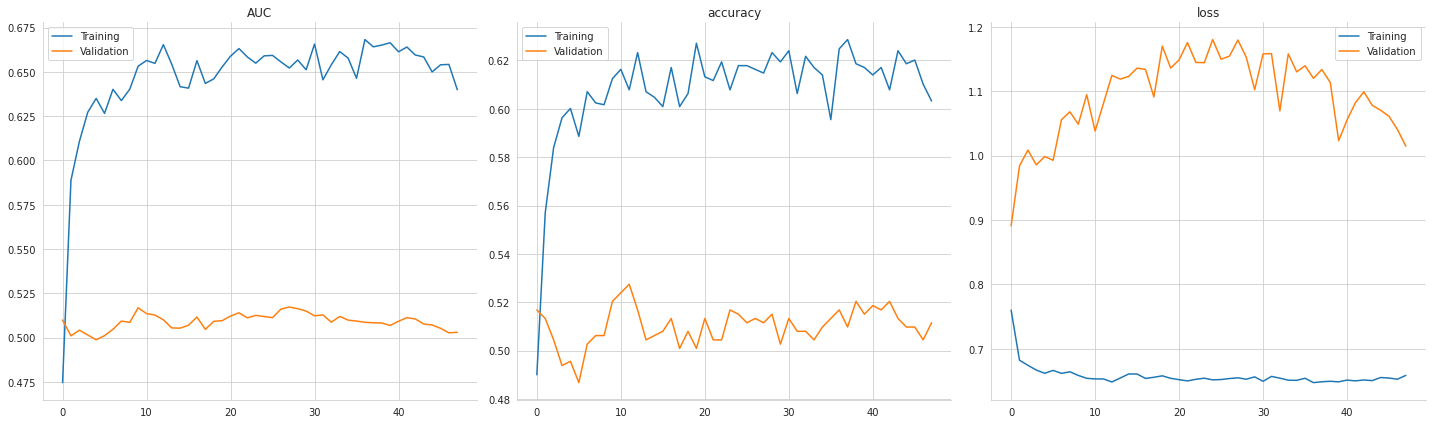

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
for i, (metric, hist) in enumerate(loss_history.groupby(which_metric, axis=1)):
    hist.plot(ax=axes[i], title=metric)
    axes[i].legend(['Training', 'Validation'])

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_stacked_classification_all_features', dpi=300);

In [ ]:
val_data = data.drop('fwd_returns', axis=1).loc['2016-04':]  # leave june as out of sample testing
X_val = [
           val_data.loc[:, sequence].values.reshape(-1, window, 1),  # get first window returns
           val_data.filter(like='topic'),  # get main news topics
        #    val_data.filter(like='sent'),   # sentiment from news
        #    val_data.filter(like='ind')     # indicators from ts
]
y_val = val_data.Label

In [ ]:
training.model.evaluate(X_val, y_val)

3/3 [==============================] - 0s 16ms/step - loss: 0.7641 - accuracy: 0.5846 - AUC: 0.5463


[0.7640821933746338, 0.5846154093742371, 0.546332061290741]

## Generating Recurrent Sequence from TS

Our time series is indexed by time as: $$x_0, x_1, \dots, x_T$$
where $\{x_i\}$ is the value in period $t$ and $T$ is the total length of the series.
To apply a RNN, we will use a sliding rolling window to construct a rolling set of input/output pairs for our model to learn from.

# Stacked LSTM

In [ ]:
indicators_df['Label'] = indicators_df['Label'].shift(-1)

In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))
df1 = indicators_df['Frac_diff_adjClose']
df1 = indicators_df['Adj Close']
df1 = np.array(df1).reshape(-1, 1)
df1=scaler.fit_transform(df1)

In [ ]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [ ]:
import numpy
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)


In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
df1 = scaler.inverse_transform(df1)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

5985.39319235497

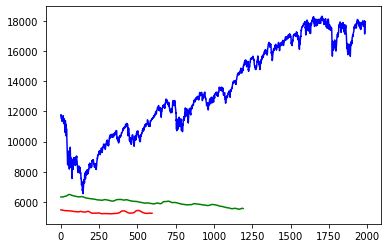

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_predict, color='green')
plt.plot(test_predict, color='red')
plt.plot(df1, color='blue')

NameError: ignored

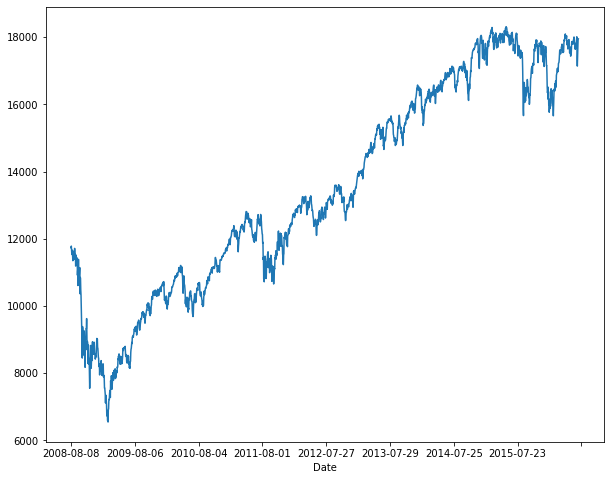

In [ ]:
plt.figure(figsize=(10, 8 ))
ax = indicators_df['Adj Close'].plot(label='Train data')
test_stock_info['Adj Close'].plot(label='Test data', ax=ax)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Adjusted Close Price', fontsize=15)
ax.set_title('Adjusted Closing prices DJIA 2008-2016', fontsize=18)
ax.legend(fontsize=12)

plt.show()